# GovSim Metrics Analysis

This notebook analyzes the metrics from GovSim simulations. It consists of two main sections:
1. Generating metrics for individual simulations
2. Comparing metrics across different simulations

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up visualization style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Define results directory
RESULTS_DIR = Path('../results')

## 1. Analyzing Individual Simulations

This section loads and analyzes data from individual simulation runs.

In [2]:
def load_simulation_data(simulation_dir):
    """Load data from a simulation directory"""
    sim_path = RESULTS_DIR / simulation_dir
    
    # Load metrics summary if available
    metrics_summary_path = sim_path / "metrics_summary.json"
    metrics_summary = None
    if metrics_summary_path.exists():
        with open(metrics_summary_path, 'r') as f:
            metrics_summary = json.load(f)
    
    # Load detailed metrics data
    metrics_data_path = sim_path / "metrics_data.csv"
    metrics_data = None
    if metrics_data_path.exists():
        metrics_data = pd.read_csv(metrics_data_path)
    
    # Load conversation data
    conversation_data_path = sim_path / "conversation_data.csv"
    conversation_data = None
    if conversation_data_path.exists():
        conversation_data = pd.read_csv(conversation_data_path)
    
    return {
        "dir_name": simulation_dir,
        "metrics_summary": metrics_summary,
        "metrics_data": metrics_data,
        "conversation_data": conversation_data
    }

In [4]:
def calculate_metrics_from_data(self, df: pd.DataFrame):
    """
    Calculate metrics by:
    1) Grouping by run
    2) Computing each run's metrics
    3) Averaging them across runs
    """

    run_ids = df["run"].unique()
    run_results = []

    # --- We identify all fisherman columns just once ---
    fishermen_columns = [col for col in df.columns if col.endswith("_caught")]
    fishermen_names = [col.replace("_caught", "") for col in fishermen_columns]

    for run_id in run_ids:
        run_df = df[df["run"] == run_id].copy()

        # -----------------------
        # (1) SURVIVAL TIME, SURVIVAL RATE
        # -----------------------
        # If you keep track of the resource level each month (e.g. in run_df["resource"]),
        # find the largest month index where the resource is still above the collapse threshold.
        # If you only store 'month' in the dataframe, you can do e.g.:
        last_month = run_df["month"].max()
        # But more accurately, you might do:
        #   valid_months = run_df[run_df["resource"] > self.config.collapse_threshold]["month"]
        #   survival_time_this_run = valid_months.max() if not valid_months.empty else 0
        # For simplicity, assume we just use the final month as "survived" if it never collapsed:
        survival_time_this_run = last_month
        # The run "fully survives" if it reaches num_months without collapse:
        survival_rate_this_run = (
            1.0 if survival_time_this_run == self.config.num_months else 0.0
        )

        # -----------------------
        # (2) TOTAL GAINS & AVERAGE GAIN
        # -----------------------
        # Sum up each fisherman’s catch for this run:
        fisherman_gains = {}
        for name in fishermen_names:
            fisherman_gains[name] = run_df[f"{name}_caught"].sum()

        # Mean across fishermen (if you want the “average gain per fisherman”):
        average_gain_this_run = sum(fisherman_gains.values()) / len(fishermen_names)

        # -----------------------
        # (3) EFFICIENCY
        # -----------------------
        # Compare total catch to the maximum "ideal" catch that keeps the resource stable.
        # For a simple measure, compare to "num_months * sustainability_threshold(initial_fish)".
        total_catch_this_run = run_df["total_caught"].sum()
        initial_sustainability_thresh = self.calculate_sustainability_threshold(
            self.config.lake_capacity
        )
        max_possible = self.config.num_months * initial_sustainability_thresh

        efficiency_this_run = 1 - max(0, (max_possible - total_catch_this_run)) / max_possible
        efficiency_this_run *= 100

        # -----------------------
        # (4) INEQUALITY (GINI)
        # -----------------------
        # Compute Gini for the final totals of each fisherman in this single run:
        total_gain_values = list(fisherman_gains.values())
        sum_all = sum(total_gain_values)
        if sum_all <= 0 or len(total_gain_values) < 2:
            inequality_this_run = 0
        else:
            sum_abs = 0
            for i in range(len(total_gain_values)):
                for j in range(len(total_gain_values)):
                    sum_abs += abs(total_gain_values[i] - total_gain_values[j])
            # 1 - sum_of_diffs / (2*N*sum_all)
            inequality_this_run = 1 - (sum_abs / (2 * len(total_gain_values) * sum_all))
            inequality_this_run *= 100

        # -----------------------
        # (5) OVER‐USAGE
        # -----------------------
        # Over‐usage is the fraction of months for which total_caught > sustainability_threshold
        # at that time.  *Group total*, not each person’s catch individually.
        # We'll do one row per month in this run:
        # (assuming each month has exactly one row with the sum in 'total_caught')
        # If your DataFrame has multiple rows per month (one per fisherman), then
        # you'd first group by month, or look for 'if row['month'] changes ...'
        over_count = 0
        total_months_run = 0
        for m in run_df["month"].unique():
            month_rows = run_df[run_df["month"] == m]
            # we assume there's exactly one row that has total_caught for the group:
            row = month_rows.iloc[0]
            if row["total_caught"] > row["sustainability_threshold"]:
                over_count += 1
            total_months_run += 1

        over_usage_this_run = (
            (over_count / total_months_run) * 100 if total_months_run > 0 else 0
        )

        # Save results
        run_results.append(
            {
                "survival_time": survival_time_this_run,
                "survival_rate": survival_rate_this_run,
                "average_gain": average_gain_this_run,
                "efficiency": efficiency_this_run,
                "inequality": inequality_this_run,
                "over_usage": over_usage_this_run,
                "fisherman_gains": fisherman_gains,
            }
        )

    # Now average across runs
    survival_time = np.mean([r["survival_time"] for r in run_results])
    survival_rate = np.mean([r["survival_rate"] for r in run_results]) * 100
    average_gain = np.mean([r["average_gain"] for r in run_results])
    efficiency = np.mean([r["efficiency"] for r in run_results])
    inequality = np.mean([r["inequality"] for r in run_results])
    over_usage = np.mean([r["over_usage"] for r in run_results])

    # Optionally, aggregate fisherman gains across runs (e.g. mean per run):
    all_names = set()
    for rr in run_results:
        all_names.update(rr["fisherman_gains"].keys())
    final_gains = {}
    for name in all_names:
        final_gains[name] = np.mean([rr["fisherman_gains"][name] for rr in run_results])

    return {
        "survival_time": survival_time,
        "survival_rate": survival_rate,
        "average_gain": average_gain,
        "individual_gains": final_gains,
        "efficiency": efficiency,
        "equality": inequality,
        "over_usage": over_usage,
    }


In [5]:
def analyze_individual_simulation(simulation_dir):
    """Analyze and visualize metrics for an individual simulation"""
    sim_data = load_simulation_data(simulation_dir)
    
    # Check if we have data
    if sim_data["metrics_data"] is None:
        print(f"No metrics data found for {simulation_dir}")
        return
    
    # Use pre-calculated metrics if available, otherwise calculate
    metrics = sim_data["metrics_summary"]
    if metrics is None:
        metrics = calculate_metrics_from_data(sim_data["metrics_data"])
        if metrics is None:
            print(f"Could not calculate metrics for {simulation_dir}")
            return
    
    # Print metrics summary
    print(f"\n--- Metrics for {simulation_dir} ---")
    print(f"Survival Time: {metrics['survival_time']:.2f}")
    print(f"Survival Rate: {metrics['survival_rate']:.2f}%")
    print(f"Average Gain: {metrics['average_gain']:.2f}")
    print(f"Efficiency: {metrics['efficiency']:.2f}%")
    print(f"Equality: {metrics['equality']:.2f}%")
    print(f"Over-usage: {metrics['over_usage']:.2f}%")
    
    # Create visualizations for the simulation
    metrics_data = sim_data["metrics_data"]
    
    # Plot 1: Fish population over time
    plt.figure(figsize=(12, 6))
    
    # Group by run and month, then plot fish before fishing
    for run in range(1, metrics_data['run'].max() + 1):
        run_data = metrics_data[metrics_data['run'] == run]
        plt.plot(run_data['month'], run_data['fish_before'], marker='o', label=f'Run {run}')
    
    plt.axhline(y=5, color='r', linestyle='--', label='Collapse Threshold')
    plt.xlabel('Month')
    plt.ylabel('Fish Population')
    plt.title('Fish Population Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Fishing decisions by agent
    # Get fishermen names
    fishermen_cols = [col for col in metrics_data.columns if col.endswith('_caught')]
    fishermen_names = [col.replace('_caught', '') for col in fishermen_cols]
    
    plt.figure(figsize=(12, 6))
    
    # Get average catch by fisherman by month across all runs
    avg_catches = metrics_data.groupby('month')[fishermen_cols].mean()
    
    # Plot average catch for each fisherman
    for i, name in enumerate(fishermen_names):
        plt.plot(avg_catches.index, avg_catches[f"{name}_caught"], marker='o', label=name)
    
    plt.xlabel('Month')
    plt.ylabel('Average Fish Caught')
    plt.title('Average Fishing Decisions by Agent')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Sustainability threshold and total catch
    plt.figure(figsize=(12, 6))
    
    # Group by month, calculate average across runs
    monthly_avg = metrics_data.groupby('month')[['total_caught', 'sustainability_threshold']].mean()
    
    plt.plot(monthly_avg.index, monthly_avg['total_caught'], marker='o', label='Total Caught')
    plt.plot(monthly_avg.index, monthly_avg['sustainability_threshold'], marker='s', label='Sustainability Threshold')
    
    plt.xlabel('Month')
    plt.ylabel('Fish')
    plt.title('Total Catch vs Sustainability Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Individual gains by fisherman
    plt.figure(figsize=(10, 6))
    
    individual_gains = metrics['individual_gains']
    plt.bar(individual_gains.keys(), individual_gains.values())
    plt.axhline(y=metrics['average_gain'], color='r', linestyle='--', label='Average')
    
    plt.xlabel('Fisherman')
    plt.ylabel('Total Gain')
    plt.title('Individual Gains by Fisherman')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return metrics

In [6]:
# Get all simulation directories
simulation_dirs = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(RESULTS_DIR / d) and d != '__pycache__']
print(f"Found {len(simulation_dirs)} simulation directories: {simulation_dirs}")

Found 1 simulation directories: ['gemma3_SocialMemoryDisabled_InheritanceDisabled_100_5_12_5']



--- Metrics for gemma3_SocialMemoryDisabled_InheritanceDisabled_100_5_12_5 ---
Survival Time: 1.00
Survival Rate: 0.00%
Average Gain: 33.33
Efficiency: 16.67%
Equality: 66.67%
Over-usage: 100.00%


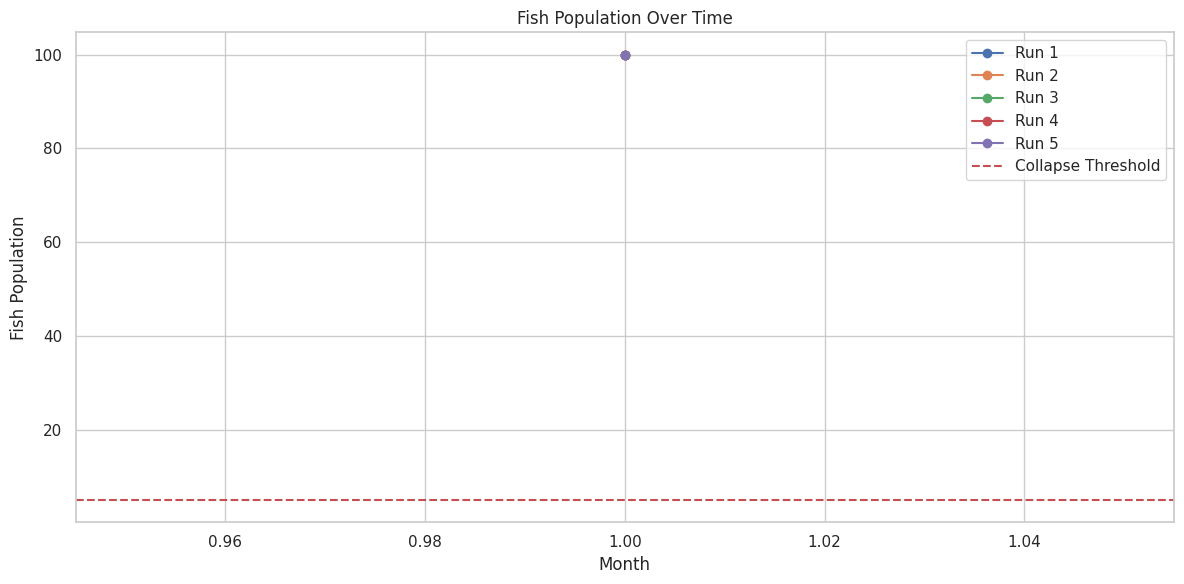

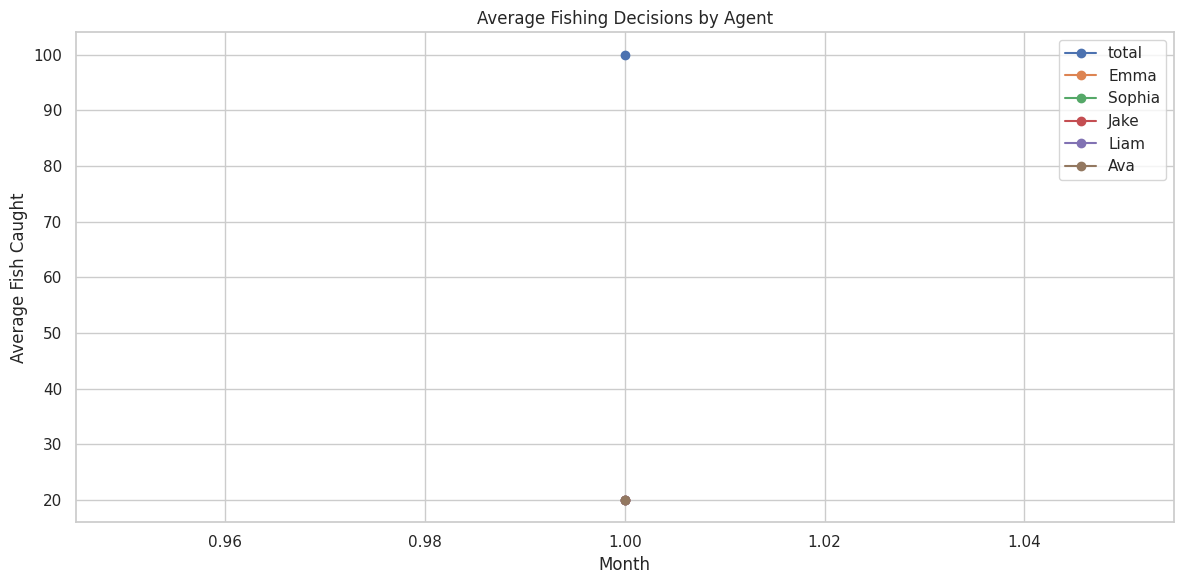

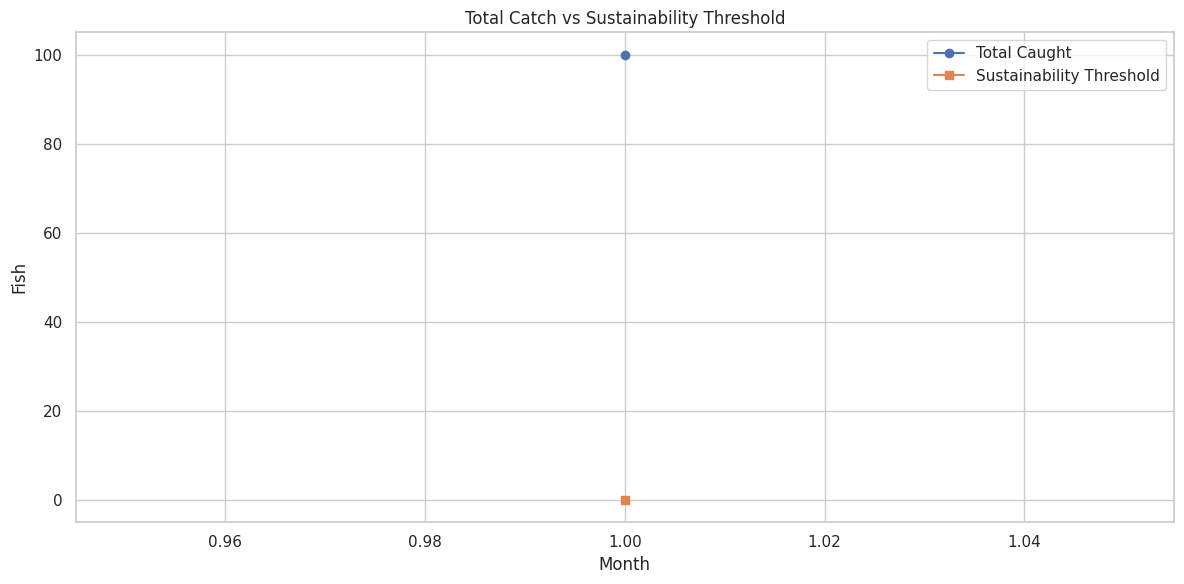

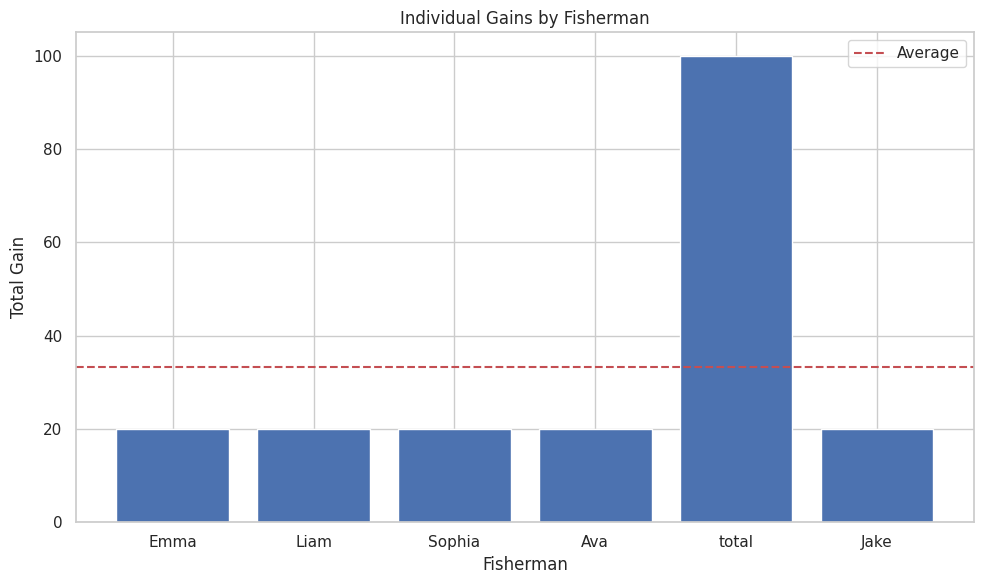

In [7]:
# Analyze a specific simulation - replace with actual directory name
if len(simulation_dirs) > 0:
    analyze_individual_simulation(simulation_dirs[0])

## 2. Comparing Multiple Simulations

This section compares metrics across different simulation runs to identify patterns and trends.

In [ ]:
def collect_simulation_metrics():
    """Collect metrics from all simulations into a dataframe"""
    all_metrics = []
    
    # Get all simulation directories
    simulation_dirs = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(RESULTS_DIR / d) and d != '__pycache__']
    
    for sim_dir in simulation_dirs:
        sim_data = load_simulation_data(sim_dir)
        
        # Check if metrics summary exists, otherwise calculate
        metrics = sim_data["metrics_summary"]
        if metrics is None and sim_data["metrics_data"] is not None:
            metrics = calculate_metrics_from_data(sim_data["metrics_data"])
        
        if metrics is not None:
            # Parse directory name to extract model and settings
            dir_parts = sim_dir.split('_')
            if len(dir_parts) >= 6:
                model_name = dir_parts[0]
                social_memory = "Enabled" in dir_parts[1]
                inheritance = "Enabled" in dir_parts[2]
                lake_capacity = int(dir_parts[3]) if dir_parts[3].isdigit() else None
                num_fishermen = int(dir_parts[4]) if dir_parts[4].isdigit() else None
                num_months = int(dir_parts[5]) if dir_parts[5].isdigit() else None
                num_runs = int(dir_parts[6]) if len(dir_parts) > 6 and dir_parts[6].isdigit() else None
            else:
                # If directory format is different, try to extract model name at least
                model_name = dir_parts[0] if len(dir_parts) > 0 else "unknown"
                social_memory = None
                inheritance = None
                lake_capacity = None
                num_fishermen = None
                num_months = None
                num_runs = None
            
            # Create a record for this simulation
            sim_record = {
                "Model": model_name,
                "SocialMemory": social_memory,
                "Inheritance": inheritance,
                "LakeCapacity": lake_capacity,
                "NumFishermen": num_fishermen,
                "NumMonths": num_months,
                "NumRuns": num_runs,
                "SurvivalRate": metrics["survival_rate"],
                "SurvivalTime": metrics["survival_time"],
                "AverageGain": metrics["average_gain"],
                "Efficiency": metrics["efficiency"],
                "Equality": metrics["equality"],
                "OverUsage": metrics["over_usage"],
                "Directory": sim_dir
            }
            all_metrics.append(sim_record)
    
    # Create DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    return metrics_df

In [ ]:
# Collect all metrics
metrics_df = collect_simulation_metrics()

# Check if we have data
if len(metrics_df) == 0:
    print("No metrics data found in any simulation directories")
else:
    # Display the comparison table
    print(f"Metrics comparison across {len(metrics_df)} simulations:\n")
    display(metrics_df)

In [ ]:
def generate_comparison_visualizations(metrics_df):
    """Generate visualizations comparing metrics across simulations"""
    if len(metrics_df) == 0:
        print("No metrics data available for visualization")
        return
    
    # 1. Model comparison chart for key metrics
    metrics_to_plot = ['SurvivalRate', 'SurvivalTime', 'Efficiency', 'Equality', 'OverUsage']
    
    # Group by model and calculate mean of metrics
    model_metrics = metrics_df.groupby('Model')[metrics_to_plot].mean().reset_index()
    
    # Create a comparison chart for each metric
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Model', y=metric, data=model_metrics)
        plt.title(f'{metric} by Model')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # 2. Social Memory and Inheritance effect
    # Filter only rows where these settings are defined
    settings_df = metrics_df.dropna(subset=['SocialMemory', 'Inheritance'])
    
    if len(settings_df) > 0:
        # Create a 2x2 grid for SocialMemory and Inheritance settings
        for metric in metrics_to_plot:
            plt.figure(figsize=(12, 8))
            
            # Create a grouped bar chart
            ax = sns.catplot(
                data=settings_df, kind="bar",
                x="SocialMemory", y=metric, hue="Inheritance",
                ci="sd", palette="dark", alpha=.6, height=6, aspect=1.5
            )
            
            plt.title(f'Effect of Social Memory and Inheritance on {metric}')
            plt.tight_layout()
            plt.show()
    
    # 3. Correlation matrix of metrics
    plt.figure(figsize=(10, 8))
    correlation_metrics = ['SurvivalRate', 'SurvivalTime', 'AverageGain', 'Efficiency', 'Equality', 'OverUsage']
    corr_matrix = metrics_df[correlation_metrics].corr()
    
    # Create heatmap of correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Metrics')
    plt.tight_layout()
    plt.show()
    
    # 4. Scatter plot matrix for key metrics
    if len(metrics_df) >= 3:  # Only create if we have enough data points
        sns.pairplot(metrics_df[correlation_metrics])
        plt.suptitle('Relationships Between Metrics', y=1.02)
        plt.tight_layout()
        plt.show()

In [ ]:
# Generate comparison visualizations if we have data
if len(metrics_df) > 0:
    generate_comparison_visualizations(metrics_df)

In [ ]:
def generate_comparison_table(metrics_df):
    """Generate a formatted comparison table like the one in the requirements"""
    if len(metrics_df) == 0:
        print("No metrics data available for table generation")
        return
    
    # Group by Model and calculate mean and std for each metric
    metrics_columns = ['SurvivalRate', 'SurvivalTime', 'AverageGain', 'Efficiency', 'Equality', 'OverUsage']
    
    # Calculate mean and std for each model
    grouped = metrics_df.groupby('Model')
    
    # Create a list to hold the formatted results
    formatted_results = []
    
    for model, group in grouped:
        row = {'Model': model}
        
        for metric in metrics_columns:
            mean_val = group[metric].mean()
            std_val = group[metric].std()
            # Format as in the requirement: mean±std
            row[metric] = f"{mean_val:.1f}±{std_val:.2f}"
        
        formatted_results.append(row)
    
    # Create DataFrame from formatted results
    formatted_df = pd.DataFrame(formatted_results)
    
    # Reorder columns to match requirement
    column_order = ['Model', 'SurvivalRate', 'SurvivalTime', 'AverageGain', 'Efficiency', 'Equality', 'OverUsage']
    formatted_df = formatted_df[column_order]
    
    # Rename columns to match requirement
    column_names = {
        'SurvivalRate': 'Survival Rate',
        'SurvivalTime': 'Survival Time',
        'AverageGain': 'Gain',
        'Efficiency': 'Efficiency',
        'Equality': 'Equality',
        'OverUsage': 'Over-usage'
    }
    formatted_df = formatted_df.rename(columns=column_names)
    
    # Display the table
    return formatted_df

In [ ]:
# Generate and display the formatted comparison table
if len(metrics_df) > 0:
    formatted_table = generate_comparison_table(metrics_df)
    print("Comparison of LLM Models on GovSim Metrics:\n")
    display(formatted_table)